<a href="https://colab.research.google.com/github/GoJian/Notebooks/blob/master/XRD_Peak_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [3]:
## This notebook analyzes XRD data from various facilities
# Library setup
import os
import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, ExcelWriter

import seaborn

import math
import random

#make smooth line interpolations
from scipy import optimize, signal
from scipy import interpolate as interpolt
from scipy.optimize import curve_fit

from lmfit import models

#set pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
#pd.set_option('display.max_rows',15)
#pd.set_option('display.max_columns',40)

#increase output width to full browser width
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

#make matplotlib inline
import matplotlib.pyplot as pyplot
%matplotlib inline
import matplotlib.cm as cm
print(pyplot.style.available[:5])
pyplot.style.use('seaborn-dark')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

['bmh', 'seaborn-dark-palette', 'seaborn-deep', 'seaborn-bright', 'seaborn-dark']


# New Section

     two_theta  intensity  two_theta_trans  intensity_norm
0    3.05       180        2.624603         0.608381      
978  51.95      252        44.284032        0.615652      
      two_theta  intensity  two_theta_trans  intensity_norm
0     2.0        51         1.721081         0.935798      
1000  52.0       31         44.325791        0.920233      
      two_theta  intensity  intensity_norm
0     5.0        0.0        0.0           
8500  90.0       0.0        0.0           
      two_theta  intensity  intensity_norm
0     5.0        0.0        0.3           
8500  90.0       0.0        0.3           


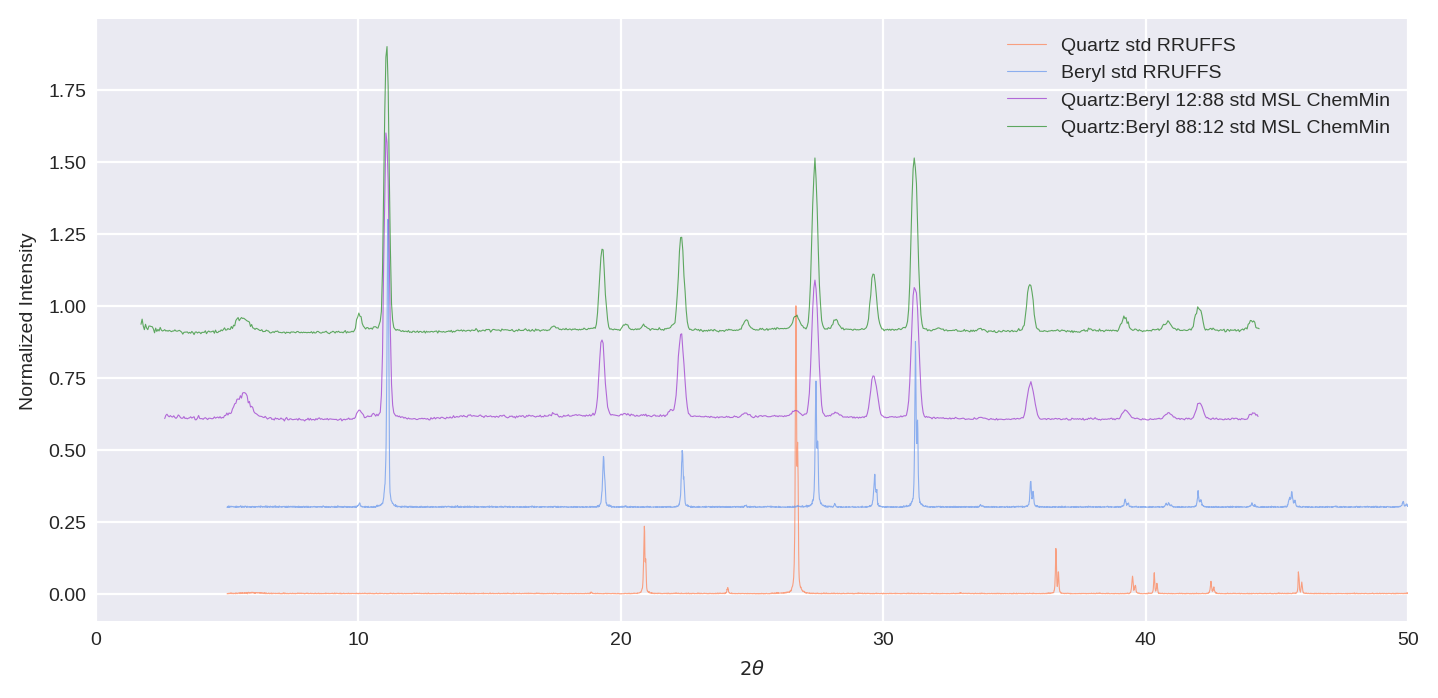

In [5]:
## Transform MSL Dataset, Check Calibrations

os.chdir(r'/content/drive/My Drive/Data_CoLab/')

data_xrd_mslstd_quartz_beryl_1 = r'MIT_XRD/MSL_ChemMin/cma_408288091rda01220050926ch11520p1_xrd_quartzberyl_12_88_standard.csv'
df_xrd_mslstd_quartz_beryl_1   = pd.read_csv(data_xrd_mslstd_quartz_beryl_1, header=1, names = ['two_theta','intensity'], comment='#')

data_xrd_mslstd_quartz_beryl_2 = r'MIT_XRD/MSL_ChemMin/cmb_484894114rda09850480000ch00111p1_quartzberyl_88_12_standard.csv'
df_xrd_mslstd_quartz_beryl_2   = pd.read_csv(data_xrd_mslstd_quartz_beryl_2, header=1, names = ['two_theta','intensity'], comment='#')

data_xrd_rruffstd_quartz = r'MIT_XRD/Rruff_Database/Quartz__R040031-1__Powder__Xray_Data_XY_Processed__3098.rruff'
df_xrd_rruffstd_quartz   = pd.read_csv(data_xrd_rruffstd_quartz, header=None, names = ['two_theta','intensity'], comment='#')

data_xrd_rruffstd_beryl  = r'MIT_XRD/Rruff_Database/Beryl__R040002-1__Powder__Xray_Data_XY_Processed__2844.rruff'
df_xrd_rruffstd_beryl    = pd.read_csv(data_xrd_rruffstd_beryl, header=None, names = ['two_theta','intensity'], comment='#')

LAMBDA_CU_LAB = 1.54056
#LAMBDA_CO_MSL = 1.7902  # Co K-alpha at 6.925 keV 
LAMBDA_CO_MSL = 1.7902 # Co K-alpha at 6.925 keV 
#LAMBDA_SYN = 1.23986   # synchrotron radiation wavelength (check experiment setting file)
#LAMBDA_SYN = 1.237 # fitting wavelength (to better match standards)

df_xrd_mslstd_quartz_beryl_1['two_theta_trans'] = 2*np.arcsin(LAMBDA_CU_LAB/LAMBDA_CO_MSL*np.sin(df_xrd_mslstd_quartz_beryl_1.two_theta/2*np.pi/180))*180/np.pi
df_xrd_mslstd_quartz_beryl_2['two_theta_trans'] = 2*np.arcsin(LAMBDA_CU_LAB/LAMBDA_CO_MSL*np.sin(df_xrd_mslstd_quartz_beryl_2.two_theta/2*np.pi/180))*180/np.pi

# Shifting factor
sf = 0.3

# Normalize intensity values
df_xrd_rruffstd_quartz['intensity_norm']=(df_xrd_rruffstd_quartz.intensity-df_xrd_rruffstd_quartz.intensity.min())/(df_xrd_rruffstd_quartz.intensity.max()-df_xrd_rruffstd_quartz.intensity.min())
df_xrd_rruffstd_beryl['intensity_norm']= sf + (df_xrd_rruffstd_beryl.intensity-df_xrd_rruffstd_beryl.intensity.min())/(df_xrd_rruffstd_beryl.intensity.max()-df_xrd_rruffstd_beryl.intensity.min())

df_xrd_mslstd_quartz_beryl_1['intensity_norm']=2*sf + (df_xrd_mslstd_quartz_beryl_1.intensity-df_xrd_mslstd_quartz_beryl_1.intensity.min())/(df_xrd_mslstd_quartz_beryl_1.intensity.max()-df_xrd_mslstd_quartz_beryl_1.intensity.min())
df_xrd_mslstd_quartz_beryl_2['intensity_norm']=3*sf + (df_xrd_mslstd_quartz_beryl_2.intensity-df_xrd_mslstd_quartz_beryl_2.intensity.min())/(df_xrd_mslstd_quartz_beryl_2.intensity.max()-df_xrd_mslstd_quartz_beryl_2.intensity.min())

# Export to file
#exportfile_mslstd_quartz_beryl_1 = 'MIT_XRD\MSL_ChemMin\cma_408288091rda01220050926ch11520p1_xrd_quartzberyl_12_88_standard_trans.csv'
#df_xrd_mslstd_quartz_beryl_1[['two_theta_trans','intensity']].to_csv(exportfile_mslstd_quartz_beryl_1, index=False)

#exportfile_mslstd_quartz_beryl_2 = 'MIT_XRD\MSL_ChemMin\cmb_484894114rda09850480000ch00111p1_quartzberyl_88_12_standard_trans.csv'
#df_xrd_mslstd_quartz_beryl_2[['two_theta_trans','intensity']].to_csv(exportfile_mslstd_quartz_beryl_2, index=False)

print( df_xrd_mslstd_quartz_beryl_1.head(1).append(df_xrd_mslstd_quartz_beryl_1.tail(1)) )
print( df_xrd_mslstd_quartz_beryl_2.head(1).append(df_xrd_mslstd_quartz_beryl_2.tail(1)) )
print( df_xrd_rruffstd_quartz.head(1).append(df_xrd_rruffstd_quartz.tail(1)) )
print( df_xrd_rruffstd_beryl.head(1).append(df_xrd_rruffstd_beryl.tail(1)) )

def cm2inch(value):
    return value/2.54

fig = pyplot.figure(figsize=(cm2inch(18.3),cm2inch(8.9))) # square plot
fig.set_dpi(200)

# To set the font size
font = {'size'   : 7}
pyplot.rc('font', **font)

# Color palates
c1 = 'coral'
c2 = 'cornflowerblue'
c3 = 'darkorchid'
c4 = 'forestgreen'
c5 = 'black'
c6 = 'yellow'

host = fig.add_subplot(111)

# Plot
host.plot(df_xrd_rruffstd_quartz['two_theta'],
          df_xrd_rruffstd_quartz['intensity_norm'],
          linewidth=0.4,
          color=c1,
          alpha=0.7,
          label='Quartz std RRUFFS')

host.plot(df_xrd_rruffstd_beryl['two_theta'],
          df_xrd_rruffstd_beryl['intensity_norm'],
          linewidth=0.4,
          color=c2,
          alpha=0.7,
          label='Beryl std RRUFFS')

host.plot(df_xrd_mslstd_quartz_beryl_1['two_theta_trans'],
          df_xrd_mslstd_quartz_beryl_1['intensity_norm'],
          linewidth=0.4,
          color=c3,
          alpha=0.7,
          label='Quartz:Beryl 12:88 std MSL ChemMin')

host.plot(df_xrd_mslstd_quartz_beryl_2['two_theta_trans'],
          df_xrd_mslstd_quartz_beryl_2['intensity_norm'],
          linewidth=0.4,
          color=c4,
          alpha=0.7,
          label='Quartz:Beryl 88:12 std MSL ChemMin')

#leg = host.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.14), fancybox=True, handlelength=0)
host.legend()
host.grid()
host.set_xlabel(r'$2\theta$')
host.set_ylabel("Normalized Intensity")

host.set_xlim([0, 50])

pyplot.tight_layout()

#saving to pdf
#filename = 'Manual_transformation_compared_to_standards.pdf'
#fig.savefig( filename, format='pdf', bbox_inches='tight')
